In [1]:
################################################################################
########################          Yelp Reviews          ######################## 
########################   Classification : LSTM        ######################## 
######################## Polarity: Negative vs Positive ########################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import numpy as np
import pandas as pd
import time
import datetime
from datetime import datetime, timedelta
from timeit import default_timer as timer
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.layers import Embedding
import matplotlib
import matplotlib.pyplot as plt

In [4]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri Apr 22 17:23:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [5]:
# Reproducibility in TF and Pytorch 
def init_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] ='true'
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [6]:
init_seeds(seed=42)

In [7]:
# # Set seed 
# seed_value = 42
# os.environ['YelpReviews_ML'] = str(seed_value)
# random.seed(seed_value)
# np.random.seed(seed_value)

In [8]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [9]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_sentimentNegPos_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (829874, 3)


,cleanReview,sentiment,stars_reviews
index,,,
1,"[order, chicken, finger, sub, honey, mustard, ...",Negative,3.0
3,"[dedicated, loving, memory, gary, feldman, gre...",Negative,5.0
12,"[absolutely, horrible, thought, would, order, ...",Negative,1.0
15,"[found, better, chicken, finger, know, inside,...",Negative,4.0
20,"[amazing, everything, tried, disappoint, chick...",Negative,5.0


In [10]:
# Examine how star reviews pairs with sentiment polarity
print(df[['stars_reviews', 'sentiment']].value_counts())

stars_reviews  sentiment
5.0            Positive     278011
1.0            Negative     231245
4.0            Positive     104585
2.0            Negative      90320
3.0            Negative      44097
4.0            Negative      26276
5.0            Negative      22999
3.0            Positive      22096
2.0            Positive       6690
1.0            Positive       3555
dtype: int64


In [11]:
# Remove comma from tokenize to make one string
df = df.copy()
df['cleanReview'] = df['cleanReview'].apply(lambda x: ','.join(map(str, x)))
df.loc[:,'cleanReview'] =  df['cleanReview'].str.replace(r',', ' ', regex=True)
df.head()

,cleanReview,sentiment,stars_reviews
index,,,
1,order chicken finger sub honey mustard sauce p...,Negative,3.0
3,dedicated loving memory gary feldman greatest ...,Negative,5.0
12,absolutely horrible thought would order place ...,Negative,1.0
15,found better chicken finger know inside crisp ...,Negative,4.0
20,amazing everything tried disappoint chicken ca...,Negative,5.0


In [12]:
# Recode to binary
df = df.copy()
df['sentiment'].mask(df['sentiment'] == 'Negative', 0, inplace=True)
df['sentiment'].mask(df['sentiment'] == 'Positive', 1, inplace=True)

print('Number of reviews per group:')
df[['sentiment']].value_counts() 

Number of reviews per group:


sentiment
0            414937
1            414937
dtype: int64

In [13]:
df = df.copy()
df['sentiment'] = df['sentiment'].astype('int')
df.dtypes

cleanReview       object
sentiment          int64
stars_reviews    float64
dtype: object

In [14]:
# Set up label and features
label = df[['sentiment']]
features = df.cleanReview

In [15]:
# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.1, stratify=label,
                                                    random_state=42)

In [16]:
class KerasTokenizer(object):
    """
    Fit and convert text to sequences for use in a Keras model.
    num_words = max number of words 
    maxlen  = max length of sequences
    """
    def __init__(self, num_words=100000, maxlen=300):
        self.tokenizer = text.Tokenizer(num_words=num_words)
        self.maxlen = maxlen
        
    def fit(self, X, y):
        self.tokenizer.fit_on_texts(X)
        return self
        
    def transform(self, X):
        return sequence.pad_sequences(self.tokenizer.texts_to_sequences(X), maxlen=self.maxlen)
    

In [17]:
km  = Pipeline([('Keras Tokenizer', KerasTokenizer(num_words=100000, maxlen=300))]) 

In [18]:
X_train = km.fit_transform(X_train)
X_test = km.fit_transform(X_test)

In [19]:
# Write results to DL Results
%cd /content/drive/MyDrive/Yelp_Reviews/DL/LSTM/SentimentPolarity/Models/

[Errno 2] No such file or directory: '/content/drive/MyDrive/Yelp_Reviews/DL/LSTM/SentimentPolarity/Models/'
/content/drive/MyDrive/Yelp_Reviews/Data


In [20]:
import datetime
!rm -rf /logs/

%load_ext tensorboard

log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [21]:
# Set up callbacks
filepath = 'Polarity_LSTM_weights_only_b1024.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='val_loss', patience = 3),
                  ModelCheckpoint(filepath, monitor='val_accuracy', 
                                  save_best_only = True, mode='max'), 
                  tensorboard_callback]

In [22]:
# Define model structure
embedding_size = 300
input_ = Input(shape=(300,))
x = Embedding(100000, embedding_size)(input_)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.0))(x) 
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_, outputs=x)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 100)         140400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [23]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=5, batch_size=1024, callbacks=callbacks_list)

Epoch 1/5
730/730 [==============================] - 321s 429ms/step - loss: 0.0311 - accuracy: 0.9888 - val_loss: 0.3813 - val_accuracy: 0.9153
Epoch 2/5
730/730 [==============================] - 315s 432ms/step - loss: 8.5788e-04 - accuracy: 0.9998 - val_loss: 0.3863 - val_accuracy: 0.9258
Epoch 3/5
730/730 [==============================] - 312s 428ms/step - loss: 2.6102e-04 - accuracy: 0.9999 - val_loss: 0.4298 - val_accuracy: 0.9233
Epoch 4/5
730/730 [==============================] - 312s 428ms/step - loss: 2.3350e-04 - accuracy: 0.9999 - val_loss: 0.5306 - val_accuracy: 0.9156


In [24]:
# Save model
model.save('./Polarity_LSTM_batch1024_5epochs_tf.h5', save_format='tf')
5
# Load model for more training or later use
#model = tf.keras.models.load_model('./Polarity_LSTM_batch1024_5epochs_tf.h5')

# Show the model architecture
#model.summary()

5

In [25]:
acc = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

2594/2594 [==============================] - 26s 10ms/step - loss: 0.5306 - accuracy: 0.9156
Test set
  Loss: 0.531
  Accuracy: 0.916


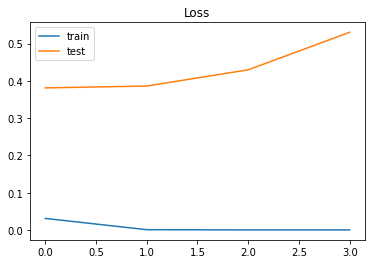

In [26]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

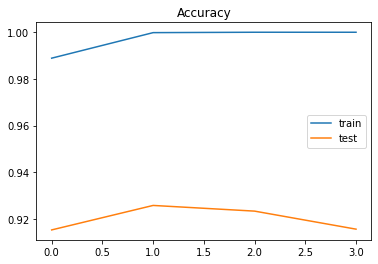

In [27]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()